In [38]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from sklearn.neighbors import BallTree
import networkx as nx
images_array = scipy.io.loadmat('faces.mat')['images'].T

In [39]:
def generate_knn_distance_matrix(data,distance_metric='euclidean',k=6):
    '''
    Takes as input a 2D array of data (n_samples,n_features)
    and applies k-nearest neighbors across samples and returns
    a thresheld distance matrix of these nearest points with all
    other notes haveing a weight of infinity.
    '''
    Balltree = BallTree(images_array,metric=distance_metric)
    neighbor_distance,neighbor_index = Balltree.query(data,k=k)
    distance_array = np.full(data.shape,999999.99)
    for i in range(0,data.shape[0]):
        for j in range(0,neighbor_index.shape[1]):
            index_j = neighbor_index[i,j]
            distance_j = neighbor_distance[i,j]
            distance_array[i,index_j] = distance_j
            
    return distance_array
        

In [40]:
def Shortest_Path(distance_matrix):
    '''
    This function takes as input a weight matrix W for node edges
    and converts it into a networkx digraph object which is used to
    efficently compute and return all node pairs shortest distance 
    via dijkstra's method.
    '''
    n = distance_matrix.shape[0]
    Graph = nx.DiGraph()
    for i in range(n):
        for j in range(n):
            Graph.add_weighted_edges_from([(i,j,min(distance_matrix[i,j], distance_matrix[j,i]))])

    res = dict(nx.all_pairs_dijkstra_path_length(Graph))
    D = np.zeros([n,n])
    for i in range(n):
        for j in range(n):
            D[i,j] = res[i][j]
            
    return D

In [41]:
def generate_centering_matrix(path_matrix):
    n = path_matrix.shape[0]
    centering_matrix = np.eye(n) - 1/n*np.ones((n,1)).dot(np.ones((n,1)).T)
    return centering_matrix

In [42]:
def Generate_Embedding(centered_distance_matrix,k=2):
    U,Sigma,V = np.linalg.svd(centered_distance_matrix)
    VT_k = V[0:k,:].T
    Sigma_k_root = np.sqrt(Sigma[0:k])
    Z =VT_k@np.diag(Sigma_k_root)
    return Z

In [43]:
def IsoMap(data,distance_metric='euclidean',k=6,embedding_dim=2):
    dist_mat = generate_knn_distance_matrix(data,distance_metric=distance_metric,k=k)
    paths = Shortest_Path(dist_mat)
    centering_matrix = generate_centering_matrix(paths)
    paths_squared = paths**2.0
    centered_distance_matrix = -0.5*centering_matrix@paths_squared@centering_matrix
    embedding = Generate_Embedding(centered_distance_matrix,k=embedding_dim)
    return embedding
    

In [46]:
embedding = IsoMap(images_array,distance_metric='cityblock',k=6)

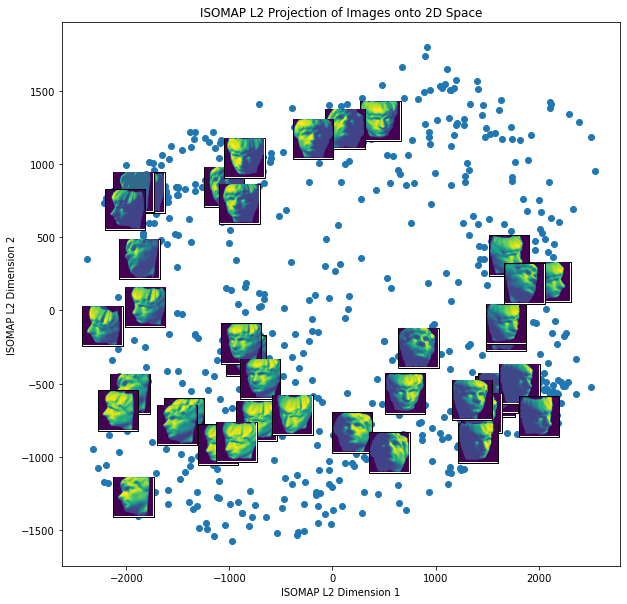

In [48]:
images_album = np.reshape(images_array,(698,64,64))
images_album_index = np.random.randint(0,images_album.shape[2],size=60)
iso_1 = embedding[:,0]
iso_2 = embedding[:,1]
fig, axs = plt.subplots(1,1,figsize=(10,10))
ax1 = axs
ax1.scatter(iso_1, iso_2)
ax1.set_title('ISOMAP L2 Projection of Images onto 2D Space')
ax1.set_xlabel('ISOMAP L2 Dimension 1')
ax1.set_ylabel('ISOMAP L2 Dimension 2')
for i in images_album_index:
    solo_image = images_album[i,:,:].T
    imagebox = OffsetImage(solo_image, zoom=0.6)
    ab = AnnotationBbox(imagebox, embedding[i,:], pad=0.1)
    ax1.add_artist(ab)
    

plt.show()